In [1]:
%load_ext autoreload
%autoreload 2
# %autoreload 2 Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.

In [33]:
port=9001

,index,word,originalText,lemma,characterOffsetBegin,characterOffsetEnd,pos,ner,before,after
0,1,Joe,Joe,Joe,0,3,NNP,PERSON,,
1,2,Smith,Smith,Smith,4,9,NNP,PERSON,,
2,3,lives,lives,live,10,15,VBZ,O,,
3,4,in,in,in,16,18,IN,O,,
4,5,California,California,California,19,29,NNP,STATE_OR_PROVINCE,,
5,6,.,.,.,29,30,.,O,,


,dep,governor,governorGloss,dependent,dependentGloss
0,ROOT,0,ROOT,3,lives
1,compound,2,Smith,1,Joe
2,nsubj,3,lives,2,Smith
3,case,5,California,4,in
4,nmod:in,3,lives,5,California
5,punct,3,lives,6,.


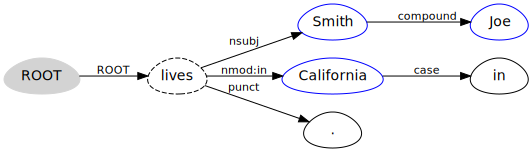

In [34]:
from sagas.nlu.stanford_helper import StanfordHelper
serv=StanfordHelper(port=port)
serv.show_deps('Joe Smith lives in California.', 'en')

In [45]:
ann=serv.parse('Joe Smith lives in California.', 'en')
openie = ann['sentences'][0]['openie']
openie

[{'subject': 'Joe Smith',
  'subjectSpan': [0, 2],
  'relation': 'lives in',
  'relationSpan': [2, 4],
  'object': 'California',
  'objectSpan': [4, 5]}]

In [46]:
import sagas
if len(openie)>0:
    display(sagas.dict_df(openie))

,subject,subjectSpan,relation,relationSpan,object,objectSpan
0,Joe Smith,"[0, 2]",lives in,"[2, 4]",California,"[4, 5]"


In [36]:
upos_maps={'JJ':'ADJ', 'RP':'ADP', 'RB':'ADV',
           'MD':'AUX', 'CC':'CCONJ', 'DT':'DET',
           'UH':'INTJ', 'NN':'NOUN', 'CD':'NUM',
           'POS':'PART', 'PRP':'PRON', 'NNP':'PROPN',
           'PUNC':'PUNCT', 'SYM':'SYM',
           'VB':'VERB', 'FW':'X'
          }
upos_rev_maps={'ADV':['RB', 'RBR', 'RBS', 'WRB'], 
               'ADJ':['JJ', 'JJR', 'JJS'],
               'DET':['DT', 'PDT', 'WDT'],
               'SYM':['NFP', 'SYM'],
               'VERB': ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
               'NOUN':['NN', 'NNS', 'DTNN'],
               'PROPN':['NNP', 'NNPS'],
               'PRON':['PRP', 'PRP$', 'WP', 'WP$', 'EX'],
               'ADP':['RP', 'IN'],
               'PART':['POS', 'TO'],
              }

def get_pos_mapping(pos, default_val='X'):
    if pos in upos_maps:
        return upos_maps[pos]
    else:
        for k, v in upos_rev_maps.items():
            if pos in v:
                return k
    return default_val

In [37]:
import sagas
# def get_pos_mapping(xpos):
#     return xpos

def extract_words(sents, lang):
    ann=serv.parse(sents, lang)
    tokens = ann['sentences'][0]['tokens']
    deps=ann['sentences'][0]['enhancedPlusPlusDependencies']
    words=[]
    for tok in tokens:
        idx=tok['index']
        dep=[d for d in deps if d['dependent']==idx][0]
        # print(dep)
        features = {'index': idx, 'text': tok['word'], 'lemma': tok['lemma'],
                    'upos': get_pos_mapping(tok['pos']), 'xpos': tok['pos'],
                    'feats': [], 'governor': dep['governor'], 
                    'dependency_relation': dep['dep'].lower(),
                    'entity': [tok['ner']]
                    }
        words.append(features)
    return words

words=extract_words('Joe Smith lives in California.', 'en')
sagas.dict_df(words)

,index,text,lemma,upos,xpos,feats,governor,dependency_relation,entity
0,1,Joe,Joe,PROPN,NNP,[],2,compound,[PERSON]
1,2,Smith,Smith,PROPN,NNP,[],3,nsubj,[PERSON]
2,3,lives,live,VERB,VBZ,[],0,root,[O]
3,4,in,in,ADP,IN,[],5,case,[O]
4,5,California,California,PROPN,NNP,[],3,nmod:in,[STATE_OR_PROVINCE]
5,6,.,.,X,.,[],3,punct,[O]


❶ verb_domains(live) _


,rel,index,text,lemma,children,features
0,nsubj,2,Smith,Smith,"[Joe, Smith]","[c_propn, x_nnp]"
1,nmod:in,5,California,California,"[in, California]","[c_propn, x_nnp]"
2,punct,6,.,.,[.],"[c_x, x_.]"


nsubj -> Joe Smith
nmod:in -> in California
index: 1	text: Joe 	lemma: Joe	upos: PROPN	xpos: NNP
index: 2	text: Smith 	lemma: Smith	upos: PROPN	xpos: NNP
index: 3	text: lives 	lemma: live	upos: VERB	xpos: VBZ
index: 4	text: in 	lemma: in	upos: ADP	xpos: IN
index: 5	text: California 	lemma: California	upos: PROPN	xpos: NNP
index: 6	text: . 	lemma: .	upos: X	xpos: .


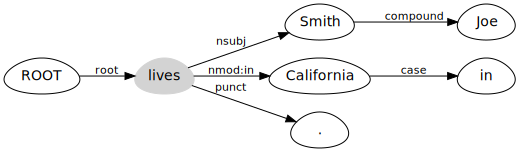

In [38]:
from sagas.nlu.uni_intf import RootWordImpl, WordIntf, SentenceIntf
from sagas.nlu.uni_viz_checker import *
class SfWordImpl(WordIntf):
    def __init__(self, data):
        super().__init__(data)

    def setup(self, token):        
        return token

class SfSentImpl(SentenceIntf):
    def setup(self, sent):
        words = []
        for word in sent:
            words.append(SfWordImpl(word))
        deps = []
        return words, deps

class SfParserImpl(object):
    def __init__(self, lang):
        self.lang = lang

    def __call__(self, sents):
        doc = extract_words(sents, self.lang)
        return SfSentImpl(doc)

viz_check(SfParserImpl, 'en', 'Joe Smith lives in California.')

❶ verb_domains(be) _


,rel,index,text,lemma,children,features


index: 1	text: I 	lemma: I	upos: PRON	xpos: PRP
index: 2	text: am 	lemma: be	upos: VERB	xpos: VBP
index: 3	text: a 	lemma: a	upos: DET	xpos: DT
index: 4	text: student 	lemma: student	upos: NOUN	xpos: NN
index: 5	text: . 	lemma: .	upos: X	xpos: .


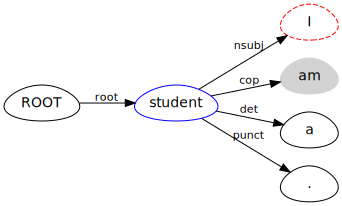

In [39]:
viz_check(SfParserImpl, 'en', 'I am a student.')

❶ verb_domains(see) _


,rel,index,text,lemma,children,features
0,nsubj,1,Bill,Bill,[Bill],"[c_propn, x_nnp]"
1,dobj,4,man,man,"[that, man]","[c_noun, x_nn]"
2,nmod:tmod,5,yesterday,yesterday,[yesterday],"[c_noun, x_nn]"
3,punct,6,.,.,[.],"[c_x, x_.]"


dobj -> that man
index: 1	text: Bill 	lemma: Bill	upos: PROPN	xpos: NNP
index: 2	text: saw 	lemma: see	upos: VERB	xpos: VBD
index: 3	text: that 	lemma: that	upos: DET	xpos: DT
index: 4	text: man 	lemma: man	upos: NOUN	xpos: NN
index: 5	text: yesterday 	lemma: yesterday	upos: NOUN	xpos: NN
index: 6	text: . 	lemma: .	upos: X	xpos: .


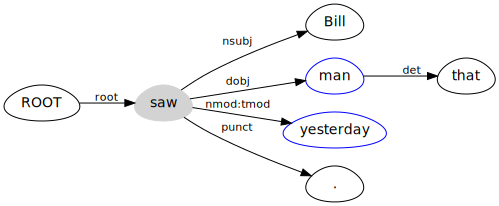

In [41]:
viz_check(SfParserImpl, 'en', 'Bill saw that man yesterday.')

3 مترجم NOUN
compound: جارك
compound: عمر
dep: رواد
punct: .
❶ root_domains(مترجم) _


,rel,index,text,lemma,children,features
0,compound,1,جارك,جارك,[جارك],"[c_propn, x_nnp]"
1,compound,2,عمر,عمر,[عمر],"[c_propn, x_nnp]"
2,dep,5,رواد,رواد,"[يا, رواد]","[c_noun, x_nn]"
3,punct,6,.,.,[.],"[c_punct, x_punc]"


dep -> يا رواد
index: 1	text: جارك 	lemma: جارك	upos: PROPN	xpos: NNP
index: 2	text: عمر 	lemma: عمر	upos: PROPN	xpos: NNP
index: 3	text: مترجم 	lemma: مترجم	upos: NOUN	xpos: NN
index: 4	text: يا 	lemma: يا	upos: ADP	xpos: RP
index: 5	text: رواد 	lemma: رواد	upos: NOUN	xpos: NN
index: 6	text: . 	lemma: .	upos: PUNCT	xpos: PUNC


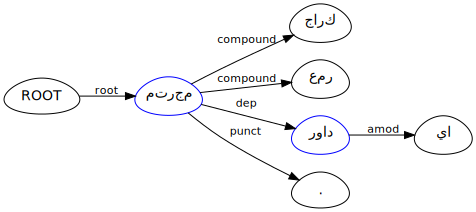

In [29]:
viz_check(SfParserImpl, 'ar', "جارَك عُمَر مُتَرْجِم يا رَواد.")

In [30]:
sagas.dict_df(extract_words("جارَك عُمَر مُتَرْجِم يا رَواد.", 'ar'))

,index,text,lemma,upos,xpos,feats,governor,dependency_relation,entity
0,1,جارك,جارك,PROPN,NNP,[],3,compound,[O]
1,2,عمر,عمر,PROPN,NNP,[],3,compound,[O]
2,3,مترجم,مترجم,NOUN,NN,[],0,root,[O]
3,4,يا,يا,ADP,RP,[],5,amod,[O]
4,5,رواد,رواد,NOUN,NN,[],3,dep,[O]
5,6,.,.,PUNCT,PUNC,[],3,punct,[O]


,index,word,originalText,lemma,characterOffsetBegin,characterOffsetEnd,pos,ner
0,1,جارك,جارَك,جارك,0,5,NNP,O
1,2,عمر,عُمَر,عمر,6,11,NNP,O
2,3,مترجم,مُتَرْجِم,مترجم,12,21,NN,O
3,4,يا,يا,يا,22,24,RP,O
4,5,رواد,رَواد,رواد,25,30,NN,O
5,6,.,.,.,30,31,PUNC,O


,dep,governor,governorGloss,dependent,dependentGloss
0,ROOT,0,ROOT,3,مترجم
1,compound,3,مترجم,1,جارك
2,compound,3,مترجم,2,عمر
3,amod,5,رواد,4,يا
4,dep,3,مترجم,5,رواد
5,punct,3,مترجم,6,.


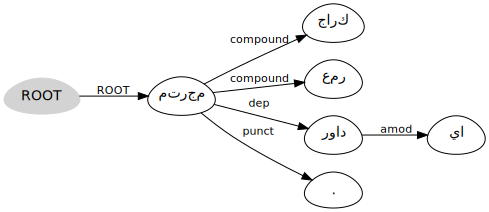

In [5]:
serv.show_deps("جارَك عُمَر مُتَرْجِم يا رَواد.", 'ar')

,index,word,originalText,lemma,characterOffsetBegin,characterOffsetEnd,pos,ner
0,1,‫,‫,‫,0,1,VBD,O
1,2,هو,هو,هو,1,3,PRP,O
2,3,هنا,هنا,هنا,4,7,RB,O
3,4,و,و,و,8,9,CC,O
4,5,هي,هي,هي,9,11,PRP,O
5,6,ايضا,أيضاً,ايضا,12,17,RB,O
6,7,.,.,.,17,18,PUNC,O


,dep,governor,governorGloss,dependent,dependentGloss
0,ROOT,0,ROOT,1,‫
1,dobj,1,‫,2,هو
2,advmod,4,و,3,هنا
3,advmod,2,هو,4,و
4,nmod:npmod,4,و,5,هي
5,advmod,5,هي,6,ايضا
6,punct,1,‫,7,.


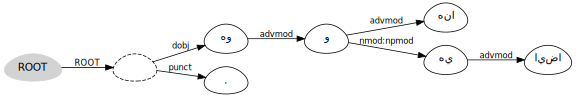

In [6]:
serv.show_deps('‫هو هنا وهي أيضاً.‬')